In [1]:
#import libraries

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import time, date, datetime

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# HISTORICAL DATA CLEANING FUNCTION

This function cleans the dataset sample_info retreive from SharePoint and outputs a dataset that is in the right format to upload to the database

In [6]:
def remove_spaces(df):
    for col in df:
        if df[col].dtype == np.dtype("object"):
            df[col] = df[col].apply(lambda x: x.strip() if type(x) == "str" else x)
    return df

In [7]:
def hist_data_cleaning(df):
    """
    The hist_data_cleaning function cleans up the historical dataset to be in the standardized format.
    This function removes untracked features, formats the date time and NaN values

    INPUT: a dataframe containing historical data
    OUTPUT: a cleaned-up dataframe of historical data
    """

    df.columns = [column.strip() for column in df.columns]
    df = remove_spaces(df)

    try:
        df.drop(
            ["FC", "Storage tracking", "Seed treatment", "Ingredient4", "Yield (%)", "Log loss", "Note"],
            axis=1, inplace=True
        )
    except:
        pass

    df.rename(columns={"FD cycle recipe": "FD recipe"}, inplace=True)

    df.dropna(subset=["FD Run ID"], inplace=True)
    # df["FD run time (hr)"] = df["FD run time (hr)"].apply(lambda x: float(x.split()[0]))

    # for col in time_feats:
    #     df[col] = pd.to_datetime(df[col], infer_datetime_format=True, format="%m/%d/%y")
        
        # df[col] = pd.to_datetime(df[col], infer_datetime_format=True, format="%m/%d/%y", errors="coerce")
    # If the values were 'Dry in PA', the command above turns str to NaT. Thus, have to revert the input
    # df["PA receive date"] = df["PA receive date"].replace({np.nan: "Dry in PA"})

    
    df["Viability (CFU/g)"] = df["Viability (CFU/g)"].replace(["#DIV/0!", "n/m"], np.NaN)
    df["Viability (CFU/g)"] = df["Viability (CFU/g)"].astype(float)
    
    df["Water activity"] = df["Water activity"].replace(["n/m"], np.NaN)
    df["Water activity"] = df["Water activity"].astype(float)

    return df

In [8]:
def convert_time_features(i):
    """
    The convert_time_features function standardizes time inputs, keeps text inputs, and passes None inputs
    """
    if i == '':
        return None
    try:
        return pd.to_datetime(i, infer_datetime_format=True, format="%m/%d/%y")
    except ValueError:
        return i

In [9]:
def feature_eng(df):
    # Time features
    time_feats = ["PA receive date", "FD start date", "EFT date", "Pelletization date"]

    for col in time_feats:
        df[col] = df[col].apply(convert_time_features)

    # Numerical features
    num_feat = [
        "EFT (hr)",
        "Broth titer (CFU/mL)",
        "Broth age (day)",
        "Cryo mix addition rate",
        "FD run time (hr)",
        "Primary ramp rate (C/min)",
        "Bulk density (g/mL)",
        "Viability (CFU/g)",
    ]

    for col in num_feat:
        try:
            df[col] = df[col].astype(float)
        except:
            pass

    # map the 'Ferm condition'
    ferm_cond_shortkey = {
        "Tryptone+Peptone": "T+P",
        "Tryptone only": "T only",
        "Glucose": "Glucose",
        "Glucose, no EPS, CR": "Glucose",
        "Peptone only, upconcentrated": "P only, con",
        "Potato peptone and tryptone, high viscosity by post-ferm addition of 0.7% XG": "T+P, 0.7% XG",
        "Peptone only": "P only",
        "Potato peptone and tryptone, low viscosity": "T+P",
        "Glucose, high EPS, CR": "Glucose",
        "tryptone only": "T only",
        "repeat of P080-22-Y007, tryptone + potato peptone": "T+P",
        "Tryptone + potato peptone, lower top feed rate, no EPS": "T+P",
        "tryptone + potato peptone, low top feed rate, no EPS, w 0.7% XG": "T+P, 0.7% XG",
        "repeat of P080-22-Y005, tryptone + potato peptone": "T+P",
        "Potato peptone only, less EPS, pH control": "P only",
        "Glucose, no EPS": "Glucose",
        "Glucose, high EPS, CR broth": "Glucose",
        "Greens": "Greens",
        "Glucose, high EPS": "Glucose"
    }
    df["FC"] = df["Ferm condition"].map(ferm_cond_shortkey)

    # Cryo coefficient
    cryo_coef = {"PVT70%": 0.285, "DSR": 0.342, "SKP": 0.380}
    df["Cryo mix Coef"] = df["Cryo mix"].map(cryo_coef)

    return df

In [37]:
def cal_yield(row):
    """
    Calculate the fermentation broth's yield
    """

    if row.isna().any():
        return np.nan
    else:
        return round((row["Viability (CFU/g)"] * row["Cryo mix Coef"] / row["Broth titer (CFU/mL)"]) * 100, 2)


def log_loss(x):
    """
    Calculate log10 loss of yield
    """

    if pd.isna(x):
        return np.nan
    else:
        return round(np.log10(x / 100), 2)

In [2]:
# Upload the historical dataset 
data = pd.read_csv('/Users/miu/IFF_st/data/raw/Pivot_SampleInfo_Hist2.csv')

In [ ]:
info_db = hist_data_cleaning(data)

In [47]:
info_db = feature_eng(info_db)

In [48]:
# Calculate the Yield and Log Loss for historical dataset
to_cal = info_db[["Broth titer (CFU/mL)", "Viability (CFU/g)", "Cryo mix Coef"]]
info_db["Yield (%)"] = to_cal.apply(cal_yield, axis=1)
info_db["Log Loss"] = info_db["Yield (%)"].apply(log_loss) 

In [49]:
# re-arrange cols order
info_db = info_db[["FD sample ID",
            "FD Run ID",
            "Strain",
            "EFT date",
            "Broth ID",
            "Fermentation Scale",
            "Ferm condition",
            "FC",
            "EFT (hr)",
            "Broth titer (CFU/mL)",
            "Broth age (day)",
            "Pelletization date",
            "Cryo mix",
            "Ingredient 1",
            "Ingredient 2",
            "Ingredient 3",
            "Cryo mix addition rate",
            "FD start date",
            "FD recipe",
            "FD pressure (mTorr)",
            "FD run time (hr)",
            "Primary ramp rate (C/min)",
            "PA receive date",
            "Dry in-house",
            "Dried appearance",
            "Container",
            "Bulk density (g/mL)",
            "Water activity",
            "Viability (CFU/g)",
            "Cryo mix Coef",
            "Yield (%)",
            "Log Loss"]]

In [50]:
info_db.describe()

,EFT (hr),Broth titer (CFU/mL),Broth age (day),Cryo mix addition rate,FD run time (hr),Primary ramp rate (C/min),Bulk density (g/mL),Water activity,Viability (CFU/g),Cryo mix Coef,Yield (%),Log Loss
count,98.000000,9.800000e+01,100.00000,122.000000,124.00000,60.000000,4.000,119.000000,1.210000e+02,121.000000,95.000000,95.000000
mean,47.724490,2.293163e+11,1.10000,0.332295,46.48871,0.043750,0.393,0.205714,2.866479e+11,0.303686,39.876211,-0.444632
std,1.390547,8.538942e+10,1.32954,0.094035,13.35115,0.011147,0.000,0.110820,1.682166e+11,0.034688,16.507914,0.222566
min,40.000000,1.180000e+11,0.00000,0.280000,22.00000,0.020000,0.393,0.020000,1.180000e+10,0.285000,2.990000,-1.520000
25%,48.000000,1.550000e+11,0.00000,0.280000,30.00000,0.035000,0.393,0.106000,1.440000e+11,0.285000,28.755000,-0.540000
50%,48.000000,1.895000e+11,1.00000,0.280000,53.00000,0.042500,0.393,0.200000,2.700000e+11,0.285000,39.500000,-0.400000
75%,48.000000,3.290000e+11,1.00000,0.280000,56.00000,0.050000,0.393,0.290000,3.800000e+11,0.285000,50.040000,-0.300000
max,48.000000,3.720000e+11,5.00000,0.500000,64.00000,0.065000,0.393,0.430000,8.180000e+11,0.380000,89.480000,-0.050000


In [51]:
info_db.shape

(124, 32)

In [ ]:
# export the clean historical dataset to upload to the database
info_db.to_csv('sample_info_db.csv',index=False)

# Sample Info Page

**Purpose**: Record samples information. 

Note on historical data:
- is not up-to-date
- Use "FD **Sample** ID" to concatenate bkg information to other tables
- Use "FD **Run** ID" col as the *key* to join **analysis data**

Note on data handling:
- Cols to add on to the user inputs
    - 'Cryo Mix Coefficient' -> to calculate 'Yield'
- Cols needs formula for calculation
    - 'Yield (%)', 'Log loss '
- Cols to remove moving forward -> don't include in the Input
    - 'Storage tracking ','Seed treatment','Note'

In [13]:
# Import dataset
info_hist = pd.read_csv("/Users/miu/IFF_st/Data files/Pivot_SampleInfo_Hist.csv")

## A. Data Cleaning

In [14]:
# remove space before and after cols' names
info_hist.columns = [column.strip() for column in info_hist.columns]

In [15]:
info_hist.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['FD sample ID', 'FD Run ID', 'Strain', 'EFT date', 'Broth ID',
       'Fermentation Scale', 'Ferm condition', 'EFT (hr)',
       'Broth titer (CFU/mL)', 'Broth age (day)', 'Pelletization date',
       'Cryo mix', 'Ingredient 1', 'Ingredient 2', 'Ingredient 3',
       'Ingredient4', 'Cryo mix addition rate', 'FD start date',
       'FD cycle recipe', 'FD pressure (mTorr)', 'FD run time (hr)',
       'Primary ramp rate (C/min)', 'PA receive date', 'Dried appearance',
       'Container', 'Water activity', 'Viability (CFU/g)', 'Yield (%)',
       'Log loss', 'Storage tracking', 'Seed treatment', 'Note'],
      dtype='object')>

In [16]:
# Drop non-tracking cols
info_hist.drop(['Storage tracking','Seed treatment','Ingredient4','Yield (%)','Log loss','Note'], axis=1, inplace=True)
info_hist.dropna(subset='FD Run ID', inplace=True)

<Axes: >

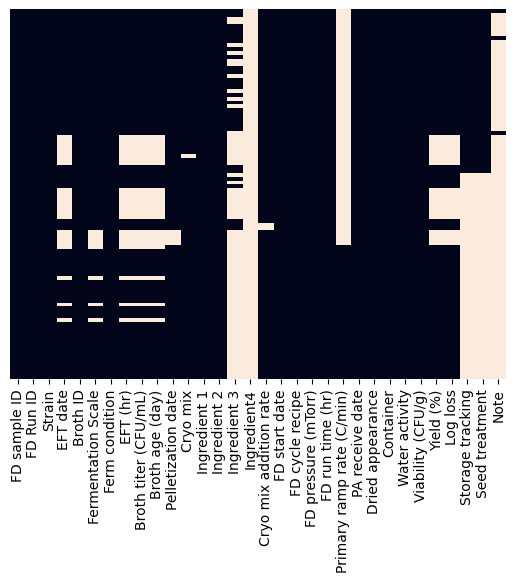

In [5]:
# check NaN values
sns.heatmap(info_hist.isnull(), yticklabels=False, cbar=False)

In [53]:
info_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FD sample ID               27 non-null     object 
 1   FD Run ID                  27 non-null     object 
 2   Strain                     27 non-null     object 
 3   EFT date                   24 non-null     object 
 4   Broth ID                   27 non-null     object 
 5   Fermentation Scale         24 non-null     object 
 6   Ferm condition             27 non-null     object 
 7   EFT (hr)                   24 non-null     float64
 8   Broth titer (CFU/mL)       24 non-null     float64
 9   Broth age (day)            24 non-null     float64
 10  Pelletization date         27 non-null     object 
 11  Cryo mix                   27 non-null     object 
 12  Ingredient 1               27 non-null     object 
 13  Ingredient 2               27 non-null     object 
 

### Date time

New data coming in 'PA receive date' can contain: "Dry in PA".
- Convert to right format for normal date, with errors='coerce'
- Revert NaT back to 'Dry in PA'

Because if use errors='ignore' -> the normal date will not be converted to wanted format

In [54]:
time_feat = ['EFT date','Pelletization date','FD start date','PA receive date']

In [58]:
for col in time_feat:
    info_hist[col] = pd.to_datetime(info_hist[col],infer_datetime_format=True,format="%m/%d/%y",errors='coerce')

In [59]:
info_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FD sample ID               27 non-null     object        
 1   FD Run ID                  27 non-null     object        
 2   Strain                     27 non-null     object        
 3   EFT date                   24 non-null     datetime64[ns]
 4   Broth ID                   27 non-null     object        
 5   Fermentation Scale         24 non-null     object        
 6   Ferm condition             27 non-null     object        
 7   EFT (hr)                   24 non-null     float64       
 8   Broth titer (CFU/mL)       24 non-null     float64       
 9   Broth age (day)            24 non-null     float64       
 10  Pelletization date         27 non-null     datetime64[ns]
 11  Cryo mix                   27 non-null     object        
 12  Ingredient

In [60]:
info_hist[['EFT date','Pelletization date','FD start date','PA receive date']]

,EFT date,Pelletization date,FD start date,PA receive date
0,NaT,2022-12-28,2023-04-03,2023-04-05
1,2023-02-24,2023-02-27,2023-04-03,2023-04-05
2,2023-02-24,2023-02-27,2023-04-03,2023-04-05
3,2023-02-24,2023-02-27,2023-04-03,2023-04-05
4,2023-02-24,2023-02-27,2023-04-05,2023-04-12
5,2023-02-24,2023-02-27,2023-04-05,2023-04-12
6,2023-02-24,2023-02-27,2023-04-05,2023-04-12
7,NaT,2022-12-28,2023-04-07,2023-04-12
8,2023-02-24,2023-02-27,2023-04-07,2023-04-12
9,2023-02-24,2023-02-27,2023-04-07,2023-04-12


In [61]:
info_hist['PA receive date'] = info_hist['PA receive date'].replace({np.nan: 'Dry in PA'})

In [62]:
info_hist[['EFT date','Pelletization date','FD start date','PA receive date']]

,EFT date,Pelletization date,FD start date,PA receive date
0,NaT,2022-12-28,2023-04-03,2023-04-05 00:00:00
1,2023-02-24,2023-02-27,2023-04-03,2023-04-05 00:00:00
2,2023-02-24,2023-02-27,2023-04-03,2023-04-05 00:00:00
3,2023-02-24,2023-02-27,2023-04-03,2023-04-05 00:00:00
4,2023-02-24,2023-02-27,2023-04-05,2023-04-12 00:00:00
5,2023-02-24,2023-02-27,2023-04-05,2023-04-12 00:00:00
6,2023-02-24,2023-02-27,2023-04-05,2023-04-12 00:00:00
7,NaT,2022-12-28,2023-04-07,2023-04-12 00:00:00
8,2023-02-24,2023-02-27,2023-04-07,2023-04-12 00:00:00
9,2023-02-24,2023-02-27,2023-04-07,2023-04-12 00:00:00


In [47]:
info_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FD sample ID               27 non-null     object        
 1   FD Run ID                  27 non-null     object        
 2   Strain                     27 non-null     object        
 3   EFT date                   24 non-null     datetime64[ns]
 4   Broth ID                   27 non-null     object        
 5   Fermentation Scale         24 non-null     object        
 6   Ferm condition             27 non-null     object        
 7   EFT (hr)                   24 non-null     float64       
 8   Broth titer (CFU/mL)       24 non-null     float64       
 9   Broth age (day)            24 non-null     float64       
 10  Pelletization date         27 non-null     datetime64[ns]
 11  Cryo mix                   27 non-null     object        
 12  Ingredient

### Numerical Features 

**FD run time (hr):** remove the str 'hr' and convert to float

In [12]:
info_hist['FD run time (hr)'][0].split()[0]

'57'

In [ ]:
info_hist['FD run time (hr)'] = info_hist['FD run time (hr)'].apply(lambda x:float(x.split()[0]))

In [14]:
info_hist['FD run time (hr)']

0     57.0
1     57.0
2     57.0
3     57.0
4     57.0
      ... 
65    22.0
66    25.0
67    25.0
68    25.0
69    25.0
Name: FD run time (hr), Length: 70, dtype: float64

**'Viability (CFU/g)'**: replace '#DIV/0!' and 'n/m' with NaN, convert to float

In [17]:
info_hist['Viability (CFU/g)'] = info_hist['Viability (CFU/g)'].replace(['#DIV/0!','n/m'], np.NaN)
info_hist['Viability (CFU/g)'] = info_hist['Viability (CFU/g)'].astype(float)

In [18]:
info_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FD sample ID               70 non-null     object        
 1   FD Run ID                  70 non-null     object        
 2   Strain                     70 non-null     object        
 3   EFT date                   49 non-null     datetime64[ns]
 4   Broth ID                   70 non-null     object        
 5   Fermentation Scale         65 non-null     object        
 6   Ferm condition             70 non-null     object        
 7   EFT (hr)                   49 non-null     float64       
 8   Broth titer (CFU/mL)       49 non-null     float64       
 9   Broth age (day)            49 non-null     float64       
 10  Pelletization date         66 non-null     datetime64[ns]
 11  Cryo mix                   69 non-null     object        
 12  Ingredient

## B. Feature Engineering

In [19]:
cryo_coef = {
    'PVT70%': 0.285,
    'DSR': 0.342,
    'SKP': 0.380
}

In [20]:
info_hist['Cryo mix Coef'] = info_hist['Cryo mix'].map(cryo_coef)

In [22]:
to_cal = info_hist[['Broth titer (CFU/mL)','Viability (CFU/g)','Cryo mix Coef']]

In [23]:
to_cal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Broth titer (CFU/mL)  49 non-null     float64
 1   Viability (CFU/g)     67 non-null     float64
 2   Cryo mix Coef         69 non-null     float64
dtypes: float64(3)
memory usage: 4.2 KB


In [24]:
to_cal.head()

,Broth titer (CFU/mL),Viability (CFU/g),Cryo mix Coef
0,3.540000e+11,NaN,0.380
1,3.540000e+11,1.840000e+11,0.342
2,1.180000e+11,6.610000e+10,0.285
3,3.540000e+11,3.150000e+11,0.285
4,1.180000e+11,4.070000e+10,0.380


In [25]:
def cal_yield(row):
    if row.isna().any():
        return np.nan
    else:
        return round((row['Viability (CFU/g)']*row['Cryo mix Coef']/row['Broth titer (CFU/mL)'])*100,2)

In [26]:
def log_loss(x):
    if pd.isna(x):
        return np.nan
    else:
        return round(np.log10(x/100),2)

In [27]:
info_hist['Yield (%)'] = to_cal.apply(cal_yield, axis=1)

In [31]:
info_hist['Log Loss'] = info_hist['Yield (%)'].apply(log_loss)

In [32]:
info_hist.head()

,FD sample ID,FD Run ID,Strain,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),Broth titer (CFU/mL),Broth age (day),...,FD run time (hr),Primary ramp rate (C/min),PA receive date,Dried appearance,Container,Water activity,Viability (CFU/g),Cryo mix Coef,Yield (%),Log Loss
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20,fused/melted moist cake,Foil pouch,0.37,NaN,0.380,NaN,NaN
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20,"Collapse, no dust",Foil pouch,0.06,1.840000e+11,0.342,17.78,-0.75
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, high viscosity by...",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-20,"Collapse, some dust",Foil pouch,0.24,6.610000e+10,0.285,15.96,-0.80
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20,"Collapse, no dust",Foil pouch,0.05,3.150000e+11,0.285,25.36,-0.60
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, low viscosity",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-22,"friable cake, readily broke into pellets",Foil pouch,0.42,4.070000e+10,0.380,13.11,-0.88


## C. Function

In [2]:
def data_cleaning(df):
    df.columns = [column.strip() for column in df.columns]
    df.drop(['Storage tracking','Seed treatment','Ingredient4','Yield (%)','Log loss','Note'], axis=1, inplace=True)
    df.dropna(subset='FD Run ID', inplace=True)
    
    time_feat = ['EFT date','Pelletization date','FD start date','PA receive date']
    for col in time_feat:
        df[col] = pd.to_datetime(df[col],infer_datetime_format=True,format="%m/%d/%y",errors='coerce')
    df['PA receive date'] = df['PA receive date'].replace({np.nan: 'Dry in PA'})
    
    df['FD run time (hr)'] = df['FD run time (hr)'].apply(lambda x:float(x.split()[0]))
    
    df['Viability (CFU/g)'] = df['Viability (CFU/g)'].replace(['#DIV/0!','n/m'], np.NaN)
    df['Viability (CFU/g)'] = df['Viability (CFU/g)'].astype(float)
    
    return df

In [3]:
def feature_eng(df):
    cryo_coef = {
    'PVT70%': 0.285,
    'DSR': 0.342,
    'SKP': 0.380
    }
    
    df['Cryo mix Coef'] = df['Cryo mix'].map(cryo_coef)
    
    return df

In [4]:
def cal_yield(row):
    if row.isna().any():
        return np.nan
    else:
        return round((row['Viability (CFU/g)']*row['Cryo mix Coef']/row['Broth titer (CFU/mL)'])*100,2)

def log_loss(x):
    if pd.isna(x):
        return np.nan
    else:
        return round(np.log10(x/100),2)

In [8]:
def sample_info(df):
    df = data_cleaning(df)
    df = feature_eng(df)
    
    to_cal = df[['Broth titer (CFU/mL)','Viability (CFU/g)','Cryo mix Coef']]
    df['Yield (%)'] = to_cal.apply(cal_yield, axis=1)
    df['Log Loss'] = df['Yield (%)'].apply(log_loss)
    
    return df

**Unit test**

In [5]:
info = pd.read_csv("/Users/miu/IFF_st/Data files/Pivot_SampleInfo_Hist.csv")

In [9]:
info_df = sample_info(info)

In [10]:
info_df.head()

,FD sample ID,FD Run ID,Strain,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),Broth titer (CFU/mL),Broth age (day),...,FD run time (hr),Primary ramp rate (C/min),PA receive date,Dried appearance,Container,Water activity,Viability (CFU/g),Cryo mix Coef,Yield (%),Log Loss
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,fused/melted moist cake,Foil pouch,0.37,NaN,0.380,NaN,NaN
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.06,1.840000e+11,0.342,17.78,-0.75
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, high viscosity by...",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, some dust",Foil pouch,0.24,6.610000e+10,0.285,15.96,-0.80
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.05,3.150000e+11,0.285,25.36,-0.60
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, low viscosity",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-22 00:00:00,"friable cake, readily broke into pellets",Foil pouch,0.42,4.070000e+10,0.380,13.11,-0.88


In [11]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FD sample ID               97 non-null     object        
 1   FD Run ID                  97 non-null     object        
 2   Strain                     97 non-null     object        
 3   EFT date                   73 non-null     datetime64[ns]
 4   Broth ID                   97 non-null     object        
 5   Fermentation Scale         89 non-null     object        
 6   Ferm condition             97 non-null     object        
 7   EFT (hr)                   73 non-null     float64       
 8   Broth titer (CFU/mL)       73 non-null     float64       
 9   Broth age (day)            73 non-null     float64       
 10  Pelletization date         93 non-null     datetime64[ns]
 11  Cryo mix                   96 non-null     object        
 12  Ingredient

In [21]:
info_df.to_csv('sample_info.csv',index=False)

---

In [13]:
inpack_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unique ID', 'FD sample ID', 'FD Run ID', 'Strain', 'Cryo mix',
       'Sub-Sample', 'Ferm Condition', 'Storage form', 'Temperature (°C)',
       'Container', 'Bulking', 'Desiccant', 'Quantity (g)', 'Sample location',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],
      dtype='object')>

In [14]:
inpack_df.drop(['Unique ID','Quantity (g)','Sample location','Week 0 Aw',
                'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],axis=1,inplace=True)

**Structure of final In-pack report TO ACHIEVE**

In [15]:
inpack_df.head()

,FD sample ID,FD Run ID,Strain,Cryo mix,Sub-Sample,Ferm Condition,Storage form,Temperature (°C),Container,Bulking,...,Week 2 CFU/g,Week 4 CFU/g,Week 8 CFU/g,Week 12 CFU/g,decay_rate_fitted,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10
0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_n,"Greens, high EPS",Pellet,21,Mylar,PVT,...,NaN,2.584000e+11,1.490000e+11,NaN,-0.007761,0.996659,0.000881,-0.008642,-0.006880,168.374192
1,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_cacl2,"Greens, high EPS",Pellet,21,Mylar,PVT,...,NaN,2.698000e+11,9.500000e+10,NaN,-0.011252,0.939662,0.005588,-0.016840,-0.005663,116.142074
2,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,unbulked powder_21_mylar_n,"Greens, high EPS",Unbulked powder,21,Mylar,PVT,...,NaN,1.774600e+11,5.624000e+10,NaN,-0.015220,0.990339,0.002946,-0.018166,-0.012273,85.502213
3,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, pre-dried bulking_21_mylar_n","Greens, high EPS","Bulked powder, pre-dried bulking",21,Mylar,PVT,...,NaN,1.014600e+11,4.522000e+10,NaN,-0.010955,0.993116,0.001788,-0.012742,-0.009167,88.342199
4,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, w/o sio2_21_mylar_n","Greens, high EPS","Bulked powder, w/o SiO2",21,Mylar,PVT,...,NaN,9.918000e+10,3.648000e+10,NaN,-0.014549,0.998539,0.001091,-0.015640,-0.013459,73.940614


In [34]:
inpack_df.columns = [column.strip() for column in inpack_df.columns]
sample_info.columns = [column.strip() for column in sample_info.columns]

In [37]:
set(sample_info.columns).intersection(set(inpack_df.columns))

{'Container', 'Cryo mix', 'FD Run ID', 'Strain'}

In [39]:
temp = pd.merge(left=inpack_df,right=sample_info.drop(['Container', 'Cryo mix', 'Strain'], axis=1), on='FD Run ID')

In [43]:
temp.columns

Index(['FD Run ID', 'Strain', 'Cryo mix', 'Sub-Sample', 'Ferm Condition',
       'Storage form', 'Temperature (°C)', 'Container', 'Bulking', 'Desiccant',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw', 'FD sample ID',
       'EFT date', 'Broth ID', 'Fermentation Scale', 'Ferm condition',
       'EFT (hr)', 'Broth titer (CFU/mL)', 'Broth age (day)',
       'Pelletization date', 'Ingredient 1', 'Ingredient 2', 'Ingredient 3',
       'Ingredient4', 'Cryo mix addition rate', 'FD start date',
       'FD cycle recipe', 'FD pressure (mTorr)', 'FD run time (hr)',
       'Primary ramp rate (C/min)', 'PA receive date', 'Dried appearance',
       'Water activity', 'Viability (CFU/g)', 'Yield (%)', 'Log loss'],
      dtype='ob

In [44]:
cols = ['FD Run ID','Storage form','Temperature (°C)','Desiccant']
real_input_df = inpack_df[cols]

In [50]:
real_input_df

,FD Run ID,Storage form,Temperature (°C),Desiccant
0,FDL-099A,Pellet,21,N
1,FDL-099A,Pellet,21,2%CaCl2
2,FDL-099A,Unbulked powder,21,5%SIO2
3,FDL-099A,"Bulked powder, pre-dried bulking",21,5%SIO2
4,FDL-099A,"Bulked powder, w/o SiO2",21,5%SIO2
...,...,...,...,...
137,FDL-105C-T15-SKP,Bulked powder,21,5%SIO2
138,FDL-105C-T15-Try,Bulked powder,21,5%SIO2
139,FDL-105C-T14-Try,Bulked powder,21,5%SIO2
140,FDL-105D-T20-Try,Bulked powder,21,5%SIO2


In [46]:
temp = pd.merge(left=real_input_df,right=sample_info.drop(['Container', 'Cryo mix', 'Strain'], axis=1), on='FD Run ID')

In [48]:
temp.head()

,FD Run ID,Storage form,Temperature (°C),Desiccant,FD sample ID,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),...,FD cycle recipe,FD pressure (mTorr),FD run time (hr),Primary ramp rate (C/min),PA receive date,Dried appearance,Water activity,Viability (CFU/g),Yield (%),Log loss
0,FDL-105A-T02,Pellet,4,5%SIO2,22PT1202-12,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,...,PVT090-A0,110-580,57 hr,NaN,2022-12-20,"Collapse, no dust",0.06,184300000000,0.178053,-0.749452
1,FDL-105A-T02,Pellet,21,5%SIO2,22PT1202-12,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,...,PVT090-A0,110-580,57 hr,NaN,2022-12-20,"Collapse, no dust",0.06,184300000000,0.178053,-0.749452
2,FDL-105A-T02,Bulked powder,4,5%SIO2,22PT1202-12,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,...,PVT090-A0,110-580,57 hr,NaN,2022-12-20,"Collapse, no dust",0.06,184300000000,0.178053,-0.749452
3,FDL-105A-T02,Unbulked powder,21,5%SIO2,22PT1202-12,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,...,PVT090-A0,110-580,57 hr,NaN,2022-12-20,"Collapse, no dust",0.06,184300000000,0.178053,-0.749452
4,FDL-105A-T02,Bulked powder,21,5%SIO2,22PT1202-12,2022-12-01 00:00:00,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,...,PVT090-A0,110-580,57 hr,NaN,2022-12-20,"Collapse, no dust",0.06,184300000000,0.178053,-0.749452


In [49]:
temp.columns

Index(['FD Run ID', 'Storage form', 'Temperature (°C)', 'Desiccant',
       'FD sample ID', 'EFT date', 'Broth ID', 'Fermentation Scale',
       'Ferm condition', 'EFT (hr)', 'Broth titer (CFU/mL)', 'Broth age (day)',
       'Pelletization date', 'Ingredient 1', 'Ingredient 2', 'Ingredient 3',
       'Ingredient4', 'Cryo mix addition rate', 'FD start date',
       'FD cycle recipe', 'FD pressure (mTorr)', 'FD run time (hr)',
       'Primary ramp rate (C/min)', 'PA receive date', 'Dried appearance',
       'Water activity', 'Viability (CFU/g)', 'Yield (%)', 'Log loss'],
      dtype='object')

---

In [41]:
df = pd.DataFrame({'A':['5/2/23']})

In [42]:
df

,A
0,5/2/23


In [43]:
type(df['A'][0])

str

In [44]:
df['A'] = pd.to_datetime(df['A'],format="%m/%d/%y")

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   A       1 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 136.0 bytes
